In [214]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import colorbar
import matplotlib.colors as clrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os,glob,pickle,re,sys,json
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
import joypy
from nilearn import datasets, input_data
import pingouin as pg
import nibabel as nib
import pyls

import enigmatoolbox
from enigmatoolbox.utils.parcellation import surface_to_parcel,parcel_to_surface
from enigmatoolbox.datasets import fetch_ahba

#BrainSmash
from brainsmash.mapgen.base import Base 
from brainsmash.mapgen.eval import base_fit
from brainsmash.mapgen.stats import pearsonr, pairwise_r, nonparp

from ptitprince import half_violinplot

sns.set_context("notebook", font_scale=1.5)
sns.set_style("whitegrid")

#!{sys.prefix}/bin/pip install -e ../
import src.functions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Variables declaration and filepaths

In [3]:
os.environ["PATH"]+=':/home/tumnic/gcastrillon/workbench_v1.4.2/bin_linux64'
os.environ["QT_QPA_PLATFORM"]='offscreen'

os.environ["OUTDATED_IGNORE"]='1'
#os.environ["TEMP"]=os.path.join(os.environ["HOME"],'tmp')
os.environ["TMP"]=os.path.join(os.environ["HOME"],'tmp')
import tempfile
tempfile.tempdir=os.environ["TMP"]
#tempfile.gettempdir()

root_dir = '../data'
results_dir = '../results'
img_dir = os.path.join(root_dir,'img_files')

thr=0.25
thr_i = "%i" % (thr*100)

fc_res_label = 'cpac_v1.4.0'
dti_res_label = 'mrtrix3_v0.4.2'
pipeline='_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1' if fc_res_label=='cpac_v1.6.1' else '_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1'
ref_img = '/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz'
#!lh_dist_full = np.loadtxt('ext_data/brainsmash/example_data/LeftParcelGeodesicDistmat.txt')


conn_metric = 'degree'#'degree' 'dti' 'alff' 'gmvar' shannon_entropy
dc_type = 'weighted'#'weighted' #binarize
pet_metric = 'cmrglc'
atlas_suf = 'mmp'
vol_res = '3mm'
sthr_suf = '' #'_sthr-1'
smooth_suf = '_fwhm-6'
recon_tag='_45min'#'45sfrscanner'#'_45min'
vol_space = 'mni-'+vol_res
recon_label='_1120'
recon_tag='_45min'
qx_t0 = 22 #21 #22
qx_tend = 42 #45 #42
pvc = '_pvc-pveseg'#'_pvc-pveseg'
pvc_suf = '_pvc-pveseg' #'_pvc-pveseg'
calc_z = False # True for DTI
nmad = 2.5 if conn_metric == 'alff' else ''#2 if conn_metric == 'alff' else '' 80
freq_band= '_0.01.0.1' if conn_metric == 'alff' else '' 
z_suff=''
GSR=''# _GSR-75 '_GSR-90'
w_length=20
w_step=10
dyn_wc =''#'_wl'+str(w_length)+'ws'+str(w_step)+'_dyn_STD' #'_wl'+str(w_length)+'ws'+str(w_step)+'_dyn_VAR'
dc_z = '_z' 
y_var = pet_metric
x_var = conn_metric+dc_z
if dyn_wc!='':
    x_label='std(DC_window) [a.u.]' if  dc_z=='' else 'std(DC_window) [Z-score]'
elif conn_metric=='DTI':
    x_label='DTI strength [a.u.]'
elif conn_metric=='alff':
    x_label='ALFF [a.u.]' if  dc_z=='' else 'ALFF [Z-score]'
elif conn_metric=='shannon_entropy':
    x_label='Shannon entropy [bits]' if not len(dc_z) else 'Shannon entropy [Z-score]'
else:
    x_label=''
xlabel='DC [Z-score]' if not len(x_label) else x_label
ylabel='CMRglc [umol/(min*100g)]' if y_var == pet_metric else xlabel
xlabel=xlabel if y_var == pet_metric else 'CMRglc [umol/(min*100g)]'

#### Atlas

In [4]:
mmp_n = 360
N = '7'
n = '400'
yeo_suf = n+'_'+N+'N'
atlas_info = pd.read_csv(os.path.join(root_dir,'external','Schaefer2018_'+yeo_suf+'_order.txt'),sep='\t',header=None)
atlas_info['network'] = atlas_info[1].str.split('_').str.get(2)
nw_label2id = dict(zip(atlas_info['network'].unique(),range(1,int(N)+1)))
nw_id2label=dict(zip(range(1,int(N)+1),atlas_info['network'].unique()))
atlas_info['network_id'] = atlas_info['network'].map(nw_label2id)
atlas_roi2nw = dict(zip(atlas_info[0].tolist(), atlas_info['network_id']))
atlas_info['network_id'] = atlas_info['network'].map(nw_label2id)
yeo2mmp = enigmatoolbox.utils.parcellation.surface_to_parcel(enigmatoolbox.utils.parcellation.parcel_to_surface(atlas_info['network_id'].to_numpy(),
                                                                                                                'schaefer_{}_conte69'.format(n)),
                                                             'glasser_360_conte69',red_op='mode')
atlas_dict={}
atlas_dict['roi2network'] = dict(zip(range(1,int(mmp_n)+1),np.vectorize(nw_id2label.get)(yeo2mmp[1:].astype(int)).flatten()))
yeo_colors = np.array(pd.read_csv(getattr(datasets.fetch_atlas_yeo_2011(),'colors_'+N),sep='\s+').iloc[:,2:5]/255)
yeo_nw_colors = {nw_id2label[i+1]: (yeo_colors[i,0],yeo_colors[i,1],yeo_colors[i,2]) for i in range(len(nw_id2label))} 
atlas_dict['nw2color'] = yeo_nw_colors
ignore_nws = ['Other','None',None,'Limbic']

#### Data loading

In [226]:
load_df = True
save_df = False
plot_signden = False
plot_expansion = False
expresion_log = True
plot_mod_maps = False
voxelwise = True
s = 0.1 if voxelwise else 10
sd_res_roi_df = pd.DataFrame({})
#ylim=(5, 60) if voxelwise else (15,45)
if not load_df:
    all_avg_vox_vals = pd.DataFrame({})
    all_avg_roi_vals = pd.DataFrame({})
    total_n_subj = 0
else:
    total_n_subj = 47
    all_avg_vox_vals = pd.read_csv(os.path.join(root_dir,'gx_all-cohorts_vox_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_avg_vox_vals.columns: all_avg_vox_vals.drop(['index'], axis = 1, inplace=True)
    all_avg_roi_vals = pd.read_csv(os.path.join(root_dir,'gx_all-cohorts_roi_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_avg_roi_vals.columns: all_avg_roi_vals.drop(['index'], axis = 1, inplace=True)
    all_ind_vox_vals = pd.read_csv(os.path.join(root_dir,'individual_all-cohorts_vox_nsubj-{}_{}-{}_v1.0.csv.zip'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_ind_vox_vals.columns: all_ind_vox_vals.drop(['index'], axis = 1, inplace=True)
    with open(os.path.join(root_dir,'gx_all-cohorts_data_nsubj-{}_{}-{}_v1.1.pickle'.format(total_n_subj,conn_metric,dc_type)), 'rb') as f:
        cohorts_metadata = pickle.load(f)
    all_avg_vox_vals_with_gx_mask = pd.read_csv(os.path.join(root_dir,'gx_all-cohorts_vox_gx-mask_nsubj-{}_{}-{}_v1.0.csv.zip'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_avg_vox_vals_with_gx_mask.columns: all_avg_vox_vals_with_gx_mask.drop(['index'], axis = 1, inplace=True)
    all_ind_roi_vals = all_ind_vox_vals.groupby(['cohort','sid','roi_id'], as_index=False).median()
    
    ### UPDATE!
    sid2sex = {}
    for site in ['TUM','VIE']:
        for coh in cohorts_metadata[site].keys():
            for sidx,sid in enumerate(cohorts_metadata[site][coh]['sids']):
                sid2sex[cohorts_metadata[site][coh]['sub_pref'] % sid]= 'F' if cohorts_metadata[site][coh]['sex'][sidx]==-1 else 'M'
    
    subj_ages={'HC002':23,'HC003':24,'HC004':28,'HC006':22,'HC007':22,'HC009':42,'HC010':20,'HC012':36,'HC013':24,'HC014':25,
         's003':35,'s007':46,'s012':38,'s014':35,'s017':52,'s020':41,'s023':38,'s025':50,'s026':52,'s028':24,
         's029':42,'s030':28,'s031':25,'s032':26,'s033':22,'s034':27,'s035':24,'s036':31,'s037':27,'s038':27
        }
    ### UPDATE end

#### Colors

In [6]:
sel_cm = 'RdBu_r'
gray_c = [0.77,0.77,0.77,1]
extended_cm=np.concatenate((np.array([gray_c]),getattr(plt.cm,sel_cm)(np.arange(0,getattr(plt.cm,sel_cm).N))))

### Figure 1. Energy metabolism scales linearly with brain connectivity
#### 1A. Multimodal brain imaging

11451.64 ± 1135.62 cortical voxels across all subjects


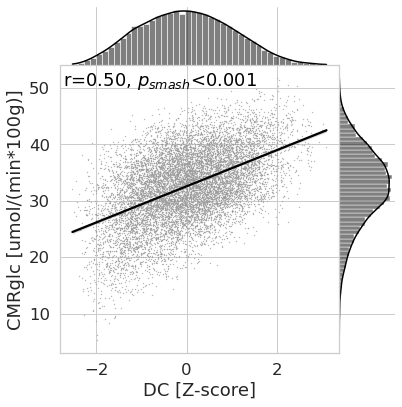

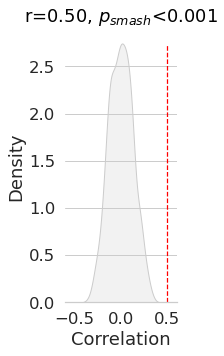

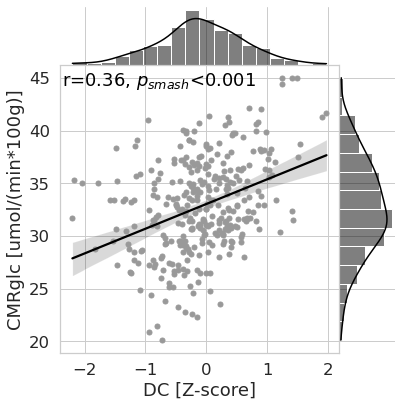

In [189]:
reference_site = 'TUM'
reference_cohort = 'a1'
example_sid = 20
example_ind_vox_vals = all_ind_vox_vals[(all_ind_vox_vals.sid==cohorts_metadata[reference_site][reference_cohort]['sub_pref'] % example_sid) & (all_ind_vox_vals.cohort==f'{reference_site}.{reference_cohort}')].copy()

## Surface representation
#src.functions.plot_surf(src.functions.metric2mmp(example_ind_vox_vals,y_var,'roi_id')[1:],os.path.join(results_dir,'figures',f'fig1A_surf-{y_var}'),
#          cmap=ListedColormap(np.concatenate((np.array(gray_c)[np.newaxis,:],getattr(plt.cm,'cividis')(np.arange(0,getattr(plt.cm,'cividis').N))))),
#          show_colorbar=True,vlow=10,vhigh=90,fig_title='individual CMRglc')
#src.functions.plot_surf(src.functions.metric2mmp(example_ind_vox_vals,x_var,'roi_id')[1:],os.path.join(results_dir,'figures',f'fig1A_surf-{x_var}'),
#          cmap=ListedColormap(np.concatenate((np.array(gray_c)[np.newaxis,:],getattr(plt.cm,'viridis')(np.arange(0,getattr(plt.cm,'viridis').N))))),
#          show_colorbar=True,vlow=10,vhigh=90,fig_title='individual DC')
#

## Individual voxelwise scatterplot
r_vox_param,_=stats.pearsonr(example_ind_vox_vals.loc[example_ind_vox_vals[conn_metric].notnull(),x_var],example_ind_vox_vals.loc[example_ind_vox_vals[conn_metric].notnull(),y_var])
p_vox_np = nonparp(r_vox_param, cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'])
p_vox_np = p_vox_np if p_vox_np>0 else 0.00001
g = src.functions.plot_joint(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np)
print(f'{all_ind_vox_vals.groupby(["sid","cohort"],as_index=False).count().roi_id.mean():.2f} ± {all_ind_vox_vals.groupby(["sid","cohort"],as_index=False).count().roi_id.std():.2f} cortical voxels across all subjects')

## Smash random distribution
plt.figure(figsize=(2,5))
src.functions.plot_rnd_dist(cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'],
                            r_vox_param,p_vox_np,plt.gca(),xlabel=xlabel,ylabel=ylabel,xlim=(-0.5,0.5),print_text=True)

## Individual ROIwise scatterplot
example_ind_roi_vals = example_ind_vox_vals.groupby('roi_id').median()
r_roi_param,_=stats.pearsonr(example_ind_roi_vals[x_var],example_ind_roi_vals[y_var])
p_roi_np = nonparp(r_roi_param, cohorts_metadata[reference_site][reference_cohort]['individual_smash'][example_sid][f'smash_{x_var}-{y_var}'])
p_roi_np = p_roi_np if p_roi_np>0 else 0.00001
g = src.functions.plot_joint(example_ind_roi_vals[x_var],example_ind_roi_vals[y_var],s=25,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_roi_np)


#### 1B. Individual subject analysis

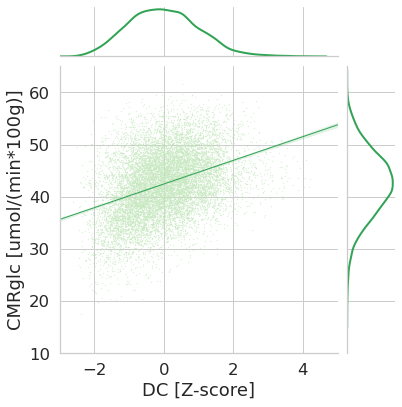

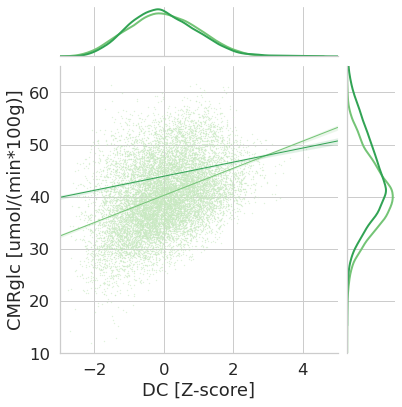

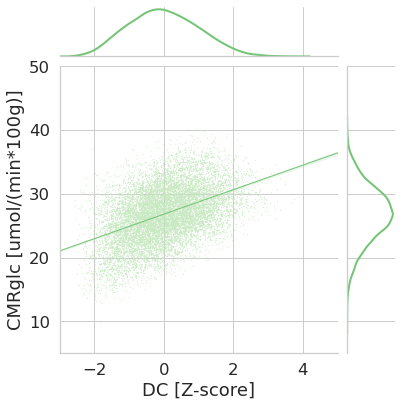

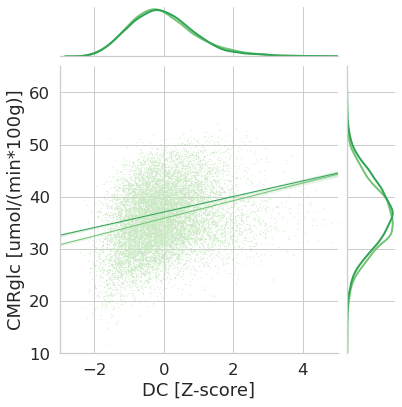

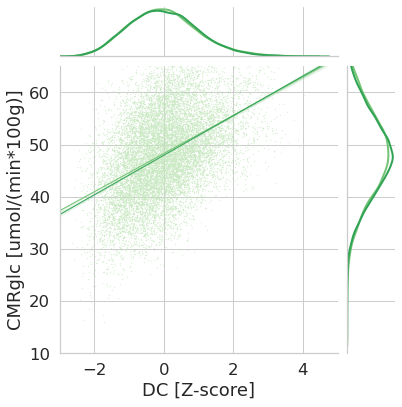

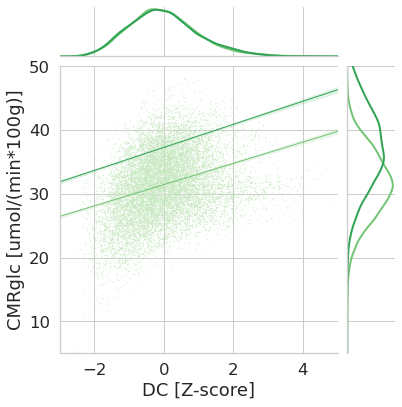

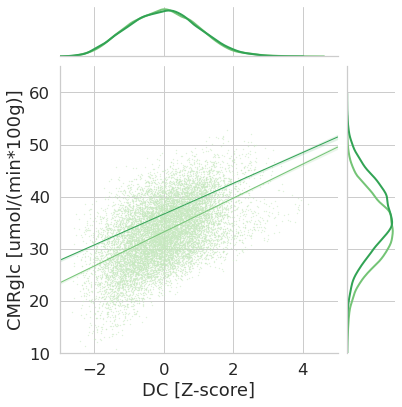

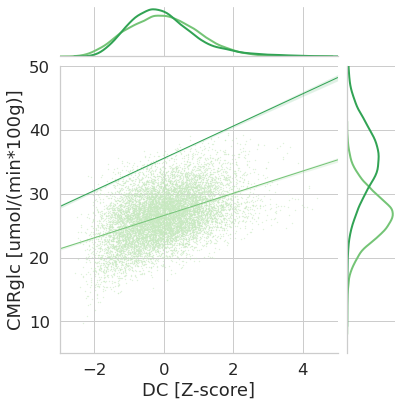

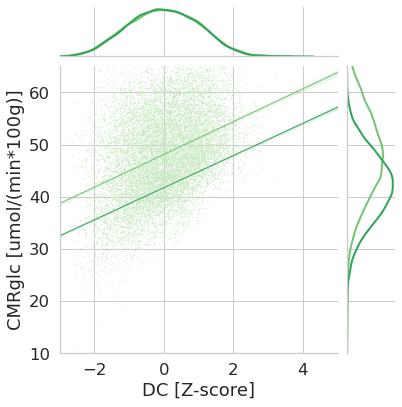

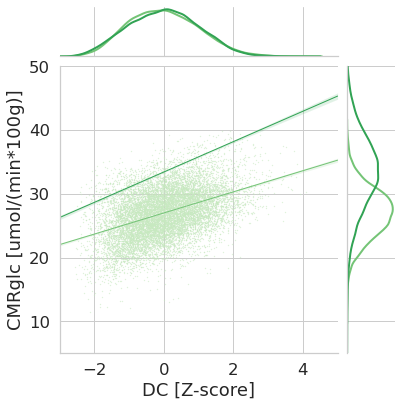

In [221]:
selected_df = all_ind_vox_vals
s = 0.1
selected_site = 'VIE' #options: TUM or VIE
coh0 = 'a1' #options: a1 or b, if the latter (replication cohort TUM), it will ignore the coh1 variable
coh1 = 'a2' #options: a2
selected_site_sids = list(np.unique(cohorts_metadata[selected_site][coh0]['sids']+cohorts_metadata[selected_site][coh1]['sids']))
s1 = f'{selected_site}.{coh0}'
s2 = f'{selected_site}.{coh1}'
scatter_color = plt.cm.tab20c([7]).flatten() if selected_site=='TUM' else plt.cm.tab20c([11]).flatten()#
if((selected_site=='TUM') & (coh0=='b')):
    scatter_color = plt.cm.tab20c([14]).flatten()
    selected_site_sids = cohorts_metadata[selected_site]['b']['sids']
for sid in selected_site_sids:#list(cohorts_metadata[selected_site]['a1']['sids']):
    subj_id = cohorts_metadata[selected_site][coh0]['sub_pref'] % sid
    ylim=(5,50) if sid not in [3,26,33] else (5,60)
    if sid in [26,28,31,34,36]: ylim=(5,40)
    if ((selected_site=='VIE') & (sid not in [4,9,12,14])): ylim=(10,65)
    selected_coh = s1 if sid in cohorts_metadata[selected_site][coh0]['sids'] else s2
    filtered_index = [((selected_df.cohort==selected_coh) & (selected_df.sid==subj_id))]
    smash_dists = [cohorts_metadata[selected_site][selected_coh.split('.')[1]]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
    cohorts_list = [s1,s2]
    color_list = [cohorts_metadata[selected_site][coh0]['color'],cohorts_metadata[selected_site][coh1]['color']]
    if((sid in cohorts_metadata[selected_site][coh1]['sids']) & (sid in cohorts_metadata[selected_site][coh0]['sids'])):
        filtered_index+=[((selected_df.cohort==s2) & (selected_df.sid==subj_id))]
        smash_dists+=[cohorts_metadata[selected_site][coh1]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list,color_list,scatter_color,
                      #[plt.cm.tab20c([5]).flatten(),plt.cm.tab20c([4]).flatten()],plt.cm.tab20c([7]).flatten(),
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
    elif(sid in cohorts_metadata[selected_site][coh1]['sids']):
        filtered_index=[((selected_df.cohort==s2) & (selected_df.sid==subj_id))]
        smash_dists=[cohorts_metadata[selected_site][coh1]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list[1:],color_list[1:],scatter_color,
                      #[plt.cm.tab20c([5]).flatten(),plt.cm.tab20c([4]).flatten()],plt.cm.tab20c([7]).flatten(),
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
    else:
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list[:1],color_list[:1],scatter_color,
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
 

Variance range = 2.9413247865336944 - 33.10101524341778; mean = 18.42; std = 6.42; p > 0.44, pairwise non-parametric tests FDR corrected
Slope range = 1.116846373151956 - 3.790573712608377; mean = 2.42; std = 0.69; p > 1.00, pairwise non-parametric tests FDR corrected
The model fit is independent of age (r = -0.18; p = 0.23; CI: [-0.44, 0.12])
The model fit is independent of sex (p = 0.43, pairwise unpaired Mann-Whitney test)


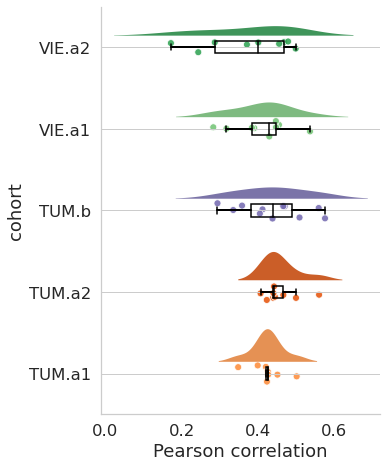

In [353]:
#if 'reg_ind_lev_df' not in locals():
reg_ind_lev_df = pd.DataFrame({},columns=['sid','sex','age','cohort', 'r', 'p', 'variance','slope'])
for site in list(cohorts_metadata.keys())[:-1]:
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())):
        cohort = f'{site}.{coh}'
        for sid in cohorts_metadata[site][coh]['sids']:
            subj_id = cohorts_metadata[site][coh]['sub_pref'] % sid
            ind_vox_vals = all_ind_vox_vals[(all_ind_vox_vals.sid==subj_id) & (all_ind_vox_vals.cohort==cohort)]
            ind_reg_dict = pg.linear_regression(ind_vox_vals[x_var],ind_vox_vals[y_var],coef_only=False,remove_na=True,as_dataframe=False)
            reg_ind_lev_df = reg_ind_lev_df.append({'sid': subj_id,'cohort':cohort, 'r':np.sqrt(ind_reg_dict['r2']), 'p':ind_reg_dict['pval'][1].astype(float), 'variance':ind_reg_dict['r2'].astype(float), 'slope':ind_reg_dict['coef'][1]}, ignore_index=True)

reg_ind_lev_df['variance'] = reg_ind_lev_df['variance'].astype('float')
            
reg_ind_lev_df['sex'] = reg_ind_lev_df['sid'].map(sid2sex)
reg_ind_lev_df['age'] = reg_ind_lev_df['sid'].map(subj_ages)
reg_ind_lev_df['r']=reg_ind_lev_df['r'].astype('float')
reg_ind_lev_df['slope']=reg_ind_lev_df['slope'].astype('float')

cohort_order = ['TUM.a1','TUM.a2','TUM.b','VIE.a1','VIE.a2']
coh_colors = {}
for coh in cohort_order:
    coh_colors[coh]=cohorts_metadata[coh.split('.')[0]][coh.split('.')[1]]['color']

f, ax = plt.subplots(figsize=(5,1.5*len(cohort_order))) #7,5
ax=half_violinplot(x='r',y='cohort',data=reg_ind_lev_df,palette=coh_colors,scale = "area", inner = None, orient = 'h',linewidth=0,order=cohort_order[::-1])
ax=sns.stripplot(x='r',y='cohort',data=reg_ind_lev_df,palette=coh_colors,edgecolor="white",size = 7, jitter = 1, zorder = 0, orient = 'h', alpha=0.88,
                         linewidth=0.88, edgecolors='w',order=cohort_order[::-1])
ax=sns.boxplot(x='r',y='cohort',data=reg_ind_lev_df, color = "black", width = .15, zorder = 10, showcaps = True,order=cohort_order[::-1], 
boxprops = {'facecolor':'none', "zorder":10},showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},saturation = 1, orient = 'h')
[s.set_visible(False) for s in [plt.gca().spines['top'], plt.gca().spines['right']]]
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(True)
plt.gca().set_xlabel('Pearson correlation')

## STATS
ind_stats = reg_ind_lev_df.describe().reset_index()
variance_diff_bet_cohorts = pg.pairwise_ttests(data=reg_ind_lev_df.groupby(['sid','sex','cohort'],as_index=False).median(),dv='variance', between=['cohort'], subject='sid',parametric=False)
variance_diff_bet_cohorts.loc[(variance_diff_bet_cohorts.A == 'TUM.a1') & (variance_diff_bet_cohorts.B == 'TUM.a2')] = pg.pairwise_ttests(data=reg_ind_lev_df[reg_ind_lev_df.cohort.isin(['TUM.a1','TUM.a2'])].groupby(['sid','sex','cohort'],as_index=False).median(),
                                     dv='variance', within=['cohort'], subject='sid',parametric=False).to_numpy()                                                                                                                                          
variance_diff_bet_cohorts.loc[(variance_diff_bet_cohorts.A == 'VIE.a1') & (variance_diff_bet_cohorts.B == 'VIE.a2')] = pg.pairwise_ttests(data=reg_ind_lev_df[reg_ind_lev_df.cohort.isin(['VIE.a1','VIE.a2'])].groupby(['sid','sex','cohort'],as_index=False).median(),
                                     dv='variance', within=['cohort'], subject='sid',parametric=False).to_numpy()
variance_diff_bet_cohorts['p-corr'] = pg.multicomp(variance_diff_bet_cohorts['p-unc'].to_numpy(),method='fdr_bh')[1]
variance_diff_bet_cohorts['p-adjust'] = 'fdr_bh'
print(f'Variance range = {" - ".join(str(val*100) for val in ind_stats.loc[ind_stats["index"].isin(["min","max"]),"variance"].to_list())}; mean = {100*ind_stats.loc[ind_stats["index"]=="mean","variance"].item():.2f}; std = {100*ind_stats.loc[ind_stats["index"]=="std","variance"].item():.2f}; p > {variance_diff_bet_cohorts["p-corr"].min():.2f}, pairwise non-parametric tests FDR corrected') # Mann-Whitney between different cohorts of subjects and Wilcoxon for wihithin subjects cohorts

slope_diff_bet_cohorts = pg.pairwise_ttests(data=reg_ind_lev_df.groupby(['sid','sex','cohort'],as_index=False).median(),dv='slope', between=['cohort'], subject='sid',parametric=False)
slope_diff_bet_cohorts.loc[(slope_diff_bet_cohorts.A == 'TUM.a1') & (slope_diff_bet_cohorts.B == 'TUM.a2')] = pg.pairwise_ttests(data=reg_ind_lev_df[reg_ind_lev_df.cohort.isin(['TUM.a1','TUM.a2'])].groupby(['sid','sex','cohort'],as_index=False).median(),
                                     dv='slope', within=['cohort'], subject='sid',parametric=False).to_numpy()                                                                                                                                          
slope_diff_bet_cohorts.loc[(slope_diff_bet_cohorts.A == 'VIE.a1') & (slope_diff_bet_cohorts.B == 'VIE.a2')] = pg.pairwise_ttests(data=reg_ind_lev_df[reg_ind_lev_df.cohort.isin(['VIE.a1','VIE.a2'])].groupby(['sid','sex','cohort'],as_index=False).median(),
                                     dv='slope', within=['cohort'], subject='sid',parametric=False).to_numpy()
slope_diff_bet_cohorts['p-corr'] = pg.multicomp(slope_diff_bet_cohorts['p-unc'].to_numpy(),method='fdr_bh')[1]
slope_diff_bet_cohorts['p-adjust'] = 'fdr_bh'
print(f'Slope range = {" - ".join(str(val) for val in ind_stats.loc[ind_stats["index"].isin(["min","max"]),"slope"].to_list())}; mean = {ind_stats.loc[ind_stats["index"]=="mean","slope"].item():.2f}; std = {ind_stats.loc[ind_stats["index"]=="std","slope"].item():.2f}; p = {slope_diff_bet_cohorts["p-corr"].min():.2f}, pairwise non-parametric tests FDR corrected') # Mann-Whitney between different cohorts of subjects and Wilcoxon for wihithin subjects cohorts

corr_ed_age = pg.corr(reg_ind_lev_df.groupby(['sid','sex','cohort'],as_index=False).median()['slope'].to_numpy(),
                               reg_ind_lev_df.groupby(['sid','sex','cohort'],as_index=False).median()['age'].to_numpy()).reset_index()
print(f'The model fit is independent of age (r = {corr_ed_age["r"].item():.2f}; p = {corr_ed_age["p-val"].item():.2f}; CI: [{corr_ed_age["CI95%"].item()[0]:.2f}, {corr_ed_age["CI95%"].item()[1]:.2f}])') 

slope_diff_bet_sex = pg.pairwise_ttests(data=reg_ind_lev_df.groupby(['sid','sex',],as_index=False).median(),
                                        dv='slope', between=['sex'], subject='sid',parametric=False)
print(f'The model fit is independent of sex (p = {slope_diff_bet_sex["p-unc"].item():.2f}, pairwise unpaired Mann-Whitney test)')

#### 1C. Group analysis voxelwise | S1 FC/DynFC/SC ROIwise

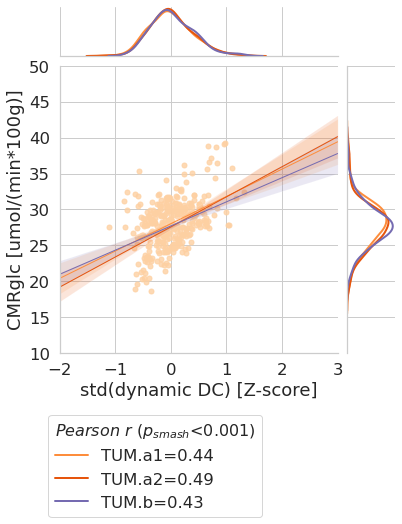

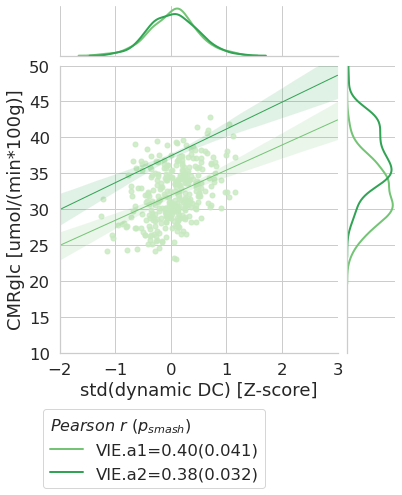

In [363]:
roiwise_results = False
other_results = 'std_dynamic_degree_z'
roiwise_results = roiwise_results if not other_results else True
all_avg_sel_vals = all_avg_roi_vals if roiwise_results else all_avg_vox_vals
sel_x_var = x_var if not other_results else other_results
sel_xlabel = xlabel if not other_results else 'SC strength [Z-score]'
sel_xlabel = xlabel if other_results != 'std_dynamic_degree_z' else 'std(dynamic DC) [Z-score]'
sel_sites = list(cohorts_metadata.keys())[:-1] if not dti_results else list(cohorts_metadata.keys())[:1]
palette_regplot_index = 5 
for site in sel_sites:
    filtered_index_lists = []
    np_null_dists = []
    filter_labels = []
    palette_regplot = []
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())):
        cohort = f'{site}.{coh}'
        filtered_index_lists += [all_avg_sel_vals.cohort==cohort]
        np_null_dists += [cohorts_metadata[site][coh]['smash_{}-{}'.format(sel_x_var,y_var)]]
        filter_labels += [cohort]
        if cix<2:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index-cix]).flatten()]
        else:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index+7]).flatten()]
    src.functions.multiple_joinplot(all_avg_sel_vals,sel_x_var,y_var,filtered_index_lists,np_null_dists,filter_labels,palette_regplot,
                                    plt.cm.tab20c([palette_regplot_index+2]).flatten(),s=25 if roiwise_results else 0.1,
                                    xlabel=sel_xlabel,ylabel=ylabel,xlim=(-2,3) if not dti_results else None,ylim=(10,50) if not dti_results else None,
                                    legend_bbox_to_anchor=(-0.07,-0.6) if site=='TUM' else (-0.09,-0.5))
    palette_regplot_index += 4
   

***Statistical differences in the variance explained by models adding the dynamic DC and SC***

In [75]:
# Run this cell tobe able to run R in the next cell, added for debugging (it can be ignored), the cell to be RUN is after the next one
%reload_ext rpy2.ipython
avg_roi_vals = all_avg_roi_vals[~(all_avg_roi_vals.cohort.isin(['VIE.a1','VIE.a2']))].groupby('roi_id',as_index=False).median()

In [182]:
%%R -i avg_roi_vals
#head(all_avg_roi_vals[all_avg_roi_vals$cohort=="TUM.a1",])
lm_simple <- lm(cmrglc ~ degree_z, data = avg_roi_vals) #all_avg_roi_vals[all_avg_roi_vals$cohort=="TUM.a1",])
lm_plus_dyndc <- lm(cmrglc ~ degree_z + std_dynamic_degree_z, data = avg_roi_vals) 
lm_plus_sc <- lm(cmrglc ~ degree_z + sc_strength_z, data = avg_roi_vals) 
lm_plus_dyndc_comp <- anova(lm_simple,lm_plus_dyndc)#[2,6]
lm_plus_sc_comp <- anova(lm_simple,lm_plus_sc)#[2,6]
summ_lm_simple <- summary(lm_simple)
summ_lm_plus_dyndc <- summary(lm_plus_dyndc)
summ_lm_plus_sc <- summary(lm_plus_sc)
#print(summary(lm_simple))
print(summ_lm_plus_sc)

#paste("Variance explained by DC ",)


Call:
lm(formula = cmrglc ~ degree_z + sc_strength_z, data = avg_roi_vals)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3665 -2.0229 -0.1977  1.7510  9.8082 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    27.8390     0.1482 187.804  < 2e-16 ***
degree_z        3.5024     0.3783   9.258  < 2e-16 ***
sc_strength_z   0.8369     0.1523   5.495 7.83e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.705 on 330 degrees of freedom
Multiple R-squared:  0.2921,	Adjusted R-squared:  0.2878 
F-statistic: 68.08 on 2 and 330 DF,  p-value: < 2.2e-16



In [188]:
#print(summ_lm_simple['adj.r.squared'][0])
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
rstats = importr('stats')
base = importr('base')
cmrglc_r = FloatVector(avg_roi_vals.cmrglc.to_list())
degree_z_r = FloatVector(avg_roi_vals.degree_z.to_list())
std_dynamic_degree_z_r = FloatVector(avg_roi_vals.std_dynamic_degree_z.to_list())
sc_strength_z_r = FloatVector(avg_roi_vals.sc_strength_z.to_list())
robjects.globalenv["cmrglc"] = cmrglc_r
robjects.globalenv["degree_z"] = degree_z_r
robjects.globalenv["std_dynamic_degree_z"] = std_dynamic_degree_z_r
robjects.globalenv["sc_strength_z"] = sc_strength_z_r
lm_simple = rstats.lm("cmrglc ~ degree_z")
robjects.globalenv["lm_simple"] = lm_simple
lm_plus_dyndc = rstats.lm("cmrglc ~ degree_z + std_dynamic_degree_z")
robjects.globalenv["lm_plus_dyndc"] = lm_plus_dyndc
lm_plus_dyndc_comp = rstats.anova(lm_simple,lm_plus_dyndc)
lm_plus_sc = rstats.lm("cmrglc ~ degree_z + sc_strength_z")
robjects.globalenv["lm_plus_sc"] = lm_plus_sc
lm_plus_sc_comp = rstats.anova(lm_simple,lm_plus_sc)

variance_lm_simple = 100*float(str(base.summary(lm_simple)[8]).split(' ')[1].replace("\n",""))
variance_lm_plus_dyndc = 100*float(str(base.summary(lm_plus_dyndc)[8]).split(' ')[1].replace("\n",""))
p_lm_plus_dyndc = float(str(lm_plus_dyndc_comp[5]).split(' ')[-1].replace("\n",""))
variance_lm_plus_sc = 100*float(str(base.summary(lm_plus_sc)[8]).split(' ')[1].replace("\n",""))
p_lm_plus_sc = float(str(lm_plus_sc_comp[5]).split(' ')[-1].replace("\n",""))

print(f'There were not statistical differences in the variance explained by the model using only DC (variance = {variance_lm_simple:.2f}%) compared to the one with the dynamic DC added (variance = {variance_lm_plus_dyndc:.2f}%, p = {p_lm_plus_dyndc:.2f} ANOVA). In contrast, the model with the strenght of the structural connectivity added, explains a significant higher variance (variance = {variance_lm_plus_sc:.2f}%, p = {p_lm_plus_sc:.2f} ANOVA)')


There were not statistical differences in the variance explained by the model using only DC (variance = 22.50%) compared to the one with the dynamic DC added (variance = 22.53%, p = 0.29 ANOVA). In contrast, the model with the strenght of the structural connectivity added, explains a significant higher variance (variance = 28.78%, p = 0.00 ANOVA)


### Figure 2. Energy density distribution
#### 2A. Calculation

[Text(0.5, 0, 'DC [Z-score]'), Text(0, 0.5, 'residual'), (-19.0, 19.0)]

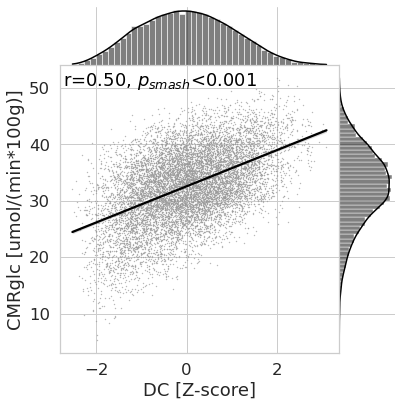

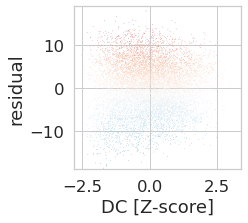

In [80]:
## Individual example
g = src.functions.plot_joint(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,
                             xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np)
#plt.suptitle(f'{cohorts_metadata[reference_site][reference_cohort]["sub_pref"] % example_sid} {reference_site}.{reference_cohort}')

plt.figure(figsize=(3,3))
example_ind_vox_vals['residual'] = pg.linear_regression(example_ind_vox_vals[x_var],example_ind_vox_vals[y_var],coef_only=False,remove_na=True,as_dataframe=False)['residuals']
sns.scatterplot(x_var,'residual',data=example_ind_vox_vals,s=3*s,legend=False,hue='residual', palette=sel_cm,
                vmin=example_ind_vox_vals.residual.quantile(0.3),vmax=example_ind_vox_vals.residual.quantile(0.7))
plt.gca().set(xlabel=xlabel,ylabel='residual',ylim=(-19,19))


#### 2B. Stability

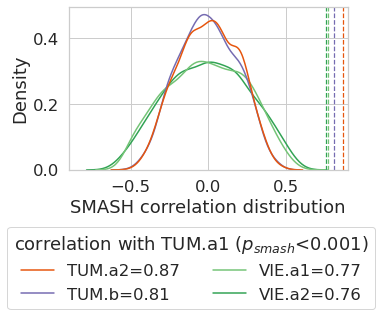

In [94]:
sd_smash_corr_bet_coh_df = pd.DataFrame({})
sd_smash_corr_bet_coh_palette = {}
for cohort in cohort_order[1:]:
    r_param,p_param=stats.pearsonr(all_avg_vox_vals_with_gx_mask.loc[all_avg_vox_vals_with_gx_mask.cohort==f'{reference_site}.{reference_cohort}','energy_density'],
                                   all_avg_vox_vals_with_gx_mask.loc[all_avg_vox_vals_with_gx_mask.cohort==cohort,'energy_density'])
    sd_smash_corr_bet_coh_df[f'{cohort}={r_param:.2f}'] = cohorts_metadata['all']['smash_sd_{}-{}'.format(f'{reference_site}.{reference_cohort}',cohort)]
    sd_smash_corr_bet_coh_palette[f'{cohort}={r_param:.2f}'] = cohorts_metadata[cohort.split('.')[0]][cohort.split('.')[1]]['color']
plt.figure(figsize=(5,3))
g = sns.kdeplot(data=sd_smash_corr_bet_coh_df,palette=sd_smash_corr_bet_coh_palette,legend=True)
legend_handles = g.get_legend().legendHandles #get_legend_handles_labels()
g.get_legend().remove()
plt.legend(handles=legend_handles,title='correlation with TUM.a1 '+r'$(p_{smash}$<0.001)', loc='upper left',ncol=2,bbox_to_anchor=(-0.25,-0.3), labels=list(sd_smash_corr_bet_coh_df.columns))
#plt.legend(legend_handles[0],legend_handles[1],title='correlation with TUM.a1 '+r'$(p_{smash}$<0.001)', loc='upper left', labels=list(sd_smash_corr_bet_coh_df.columns),ncol=2,bbox_to_anchor=(-0.25,-0.3))
plt.gca().set_xlim(-0.9,0.9)
plt.gca().set_xlabel('SMASH correlation distribution')
for ix,col in enumerate(list(sd_smash_corr_bet_coh_df.columns)):
    plt.gca().axvline(float(col.split('=')[1]), 0, 1, color=sd_smash_corr_bet_coh_palette[col], linestyle='dashed', lw=1.25)


#### 2C. Group statistics

<AxesSubplot:>

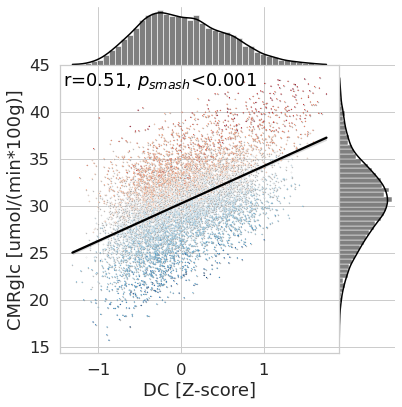

<Figure size 432x288 with 0 Axes>

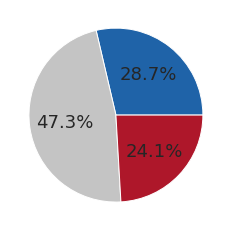

In [111]:
## Average voxel values across subjects from all cohorts using a common group GM mask
avg_vox_vals_with_gx_mask = all_avg_vox_vals_with_gx_mask.groupby('vox_id',as_index=False).median()

## Group linear relationship color coded by energy density 
r_vox_param_all,_=stats.pearsonr(avg_vox_vals_with_gx_mask.loc[avg_vox_vals_with_gx_mask[conn_metric].notnull(),x_var],
                                 avg_vox_vals_with_gx_mask.loc[avg_vox_vals_with_gx_mask[conn_metric].notnull(),y_var])
p_vox_np_all = nonparp(r_vox_param_all, cohorts_metadata['all']['smash_{}-{}'.format(x_var,y_var)])
p_vox_np_all = p_vox_np_all if p_vox_np_all>0 else 0.00001

g = src.functions.plot_joint(avg_vox_vals_with_gx_mask[x_var],avg_vox_vals_with_gx_mask[y_var],s=0.1,robust=False,kdeplot=False,truncate=True,
               xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_vox_np_all)
sns.scatterplot(x=x_var, y=y_var, hue='energy_density',data=avg_vox_vals_with_gx_mask,
                linewidth=0,s=1.5,legend=False,palette=sel_cm,ax=g.ax_joint,
                vmin=avg_vox_vals_with_gx_mask.energy_density.quantile(0.25),vmax=avg_vox_vals_with_gx_mask.energy_density.quantile(0.75))

## One sample t-test statistics across subjects
gx_gm_mask_fn = os.path.join(root_dir,'gx_between-cohort_gm-mask_25perc_mni-3mm.nii.gz')
all_sd_fn = os.path.join(root_dir,'all_47subj_ed-z_one-sample-t-test_vox_corrp_tstat1_lt_0.01_mni-3mm.nii.gz')

avg_vox_vals_with_gx_mask['ostt_mask'] = input_data.NiftiMasker(mask_img=gx_gm_mask_fn).fit_transform(all_sd_fn).flatten()[avg_vox_vals_with_gx_mask.vox_id.to_numpy()]
avg_vox_vals_with_gx_mask['ostt_signed'] = avg_vox_vals_with_gx_mask['ostt_mask'] 
avg_vox_vals_with_gx_mask.loc[(avg_vox_vals_with_gx_mask['ostt_signed']>0) & (avg_vox_vals_with_gx_mask['energy_density']<0),'ostt_signed'] = -1
avg_vox_vals_with_gx_mask.loc[(avg_vox_vals_with_gx_mask['ostt_signed']>0) & (avg_vox_vals_with_gx_mask['energy_density']>0),'ostt_signed'] = 1

one_sample_ttest_roi_df = avg_vox_vals_with_gx_mask[['roi_id','ostt_signed']].groupby('roi_id',as_index=False).agg(lambda x: stats.mode(x)[0][0])
one_sample_ttest_roi_df['ostt_mask'] = one_sample_ttest_roi_df['ostt_signed']
one_sample_ttest_roi_df.loc[one_sample_ttest_roi_df['ostt_mask']!=0,'ostt_mask']=1
plt.figure()
one_sample_ttest_roi_df.groupby('ostt_signed').count().plot(kind='pie', y='roi_id',legend=False,colors=np.concatenate((getattr(plt.cm,sel_cm)(range(256))[24][np.newaxis,:],np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[231][np.newaxis,:]),axis=0),shadow=False,autopct='%1.1f%%',xlabel='',ylabel='',labels=['','',''],startangle=0)



#### 2D. Subject and network distribution

<AxesSubplot:>

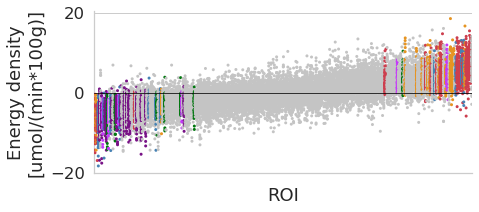

<Figure size 432x288 with 0 Axes>

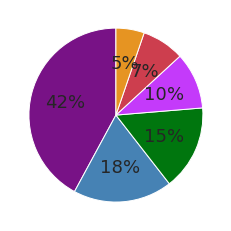

<Figure size 432x288 with 0 Axes>

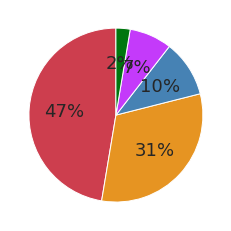

In [139]:
all_ind_roi_vals = all_ind_vox_vals.groupby(['cohort','sid','roi_id'], as_index=False).median()
all_ind_roi_vals['nw'] = all_ind_roi_vals['roi_id'].map(atlas_dict['roi2network'])
all_ind_roi_vals['nw_consistent_rois'] = all_ind_roi_vals['nw']
all_ind_roi_vals['ed_sign_consistent_rois'] = 0
for roi_id in all_ind_roi_vals.roi_id.unique():
    if np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energy_density'].to_numpy()>0)<=2:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'ed_sign_consistent_rois'] = -1
    elif np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energy_density'].to_numpy()<0)<=2:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'ed_sign_consistent_rois'] = 1
    else:
        all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'nw_consistent_rois'] = 'None'
    #if ~((np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energy_density'].to_numpy()>0)<=2) | (np.sum(all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'energy_density'].to_numpy()<0)<=2)):
    #    all_ind_roi_vals.loc[all_ind_roi_vals.roi_id==roi_id,'nw_consistent_rois'] = 'None'

nw_consistent_rois_palette = atlas_dict['nw2color']
nw_consistent_rois_palette['None'] = gray_c

roi_ids_order = all_ind_roi_vals.groupby('roi_id',as_index=False).median().sort_values(by='energy_density',ignore_index=True).roi_id.to_list()
### To test the plot with less ROIS: all_ind_roi_vals[all_ind_roi_vals.roi_id.isin(all_ind_roi_vals.roi_id.unique()[::10])]
g = sns.catplot(x='roi_id', y='energy_density', data=all_ind_roi_vals,height=3.5,aspect=2,hue='nw_consistent_rois',
                palette=nw_consistent_rois_palette,order=roi_ids_order,legend=False,s=3)
g.set(xticklabels=[])
plt.gca().set_xlabel('ROI')
plt.gca().set_ylabel('Energy density\n[umol/(min*100g)]')
plt.gca().axhline(0, 0, 1, color='k', lw=0.75,zorder=10)

avg_consistent_roi_vals = all_ind_roi_vals[all_ind_roi_vals.nw_consistent_rois!='None']
plt.figure()
avg_consistent_neg_roi_vals = avg_consistent_roi_vals[avg_consistent_roi_vals.ed_sign_consistent_rois<0].groupby(['nw','roi_id'], as_index=False).median().groupby('nw').count().sort_values(by='roi_id', ascending=False)
avg_consistent_neg_roi_vals.plot(kind='pie', y='roi_id',legend=False,shadow=False,autopct='%d%%',xlabel='',ylabel='',startangle=90,
                             labels=['','','','','',''],colors=[atlas_dict['nw2color'][cx] for cx in avg_consistent_neg_roi_vals.index.tolist()])
plt.figure()
avg_consistent_pos_roi_vals = avg_consistent_roi_vals[avg_consistent_roi_vals.ed_sign_consistent_rois>0].groupby(['nw','roi_id'], as_index=False).median().groupby('nw').count().sort_values(by='roi_id', ascending=False)
avg_consistent_pos_roi_vals.plot(kind='pie', y='roi_id',legend=False,shadow=False,autopct='%d%%',xlabel='',ylabel='',startangle=90,
                             labels=['','','','','',''],colors=[atlas_dict['nw2color'][cx] for cx in avg_consistent_pos_roi_vals.index.tolist()])


### Figure 3. Energy density distribution relates to human cognitive functions and cortical evolution
#### 3A. Cognitive functions

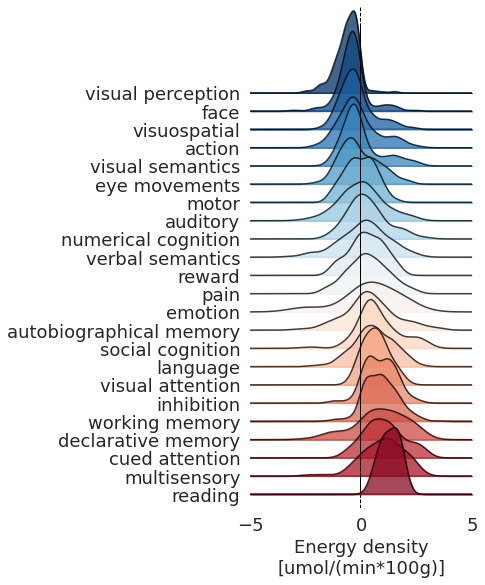

In [159]:
neurosynth_masks_df = pd.read_csv(os.path.join(root_dir,f'gx_neurosynth-masked_ed-median_cohorts-all_vox_nsubj-{total_n_subj}_{conn_metric}-{dc_type}_v1.0.csv'))
neurosynth_order = neurosynth_masks_df[neurosynth_masks_df.energy_density!=0.0].groupby('domain', as_index=False).median().sort_values(by='energy_density',ignore_index=True)
neurosynth_order['sorted_domain'] = neurosynth_order.index.astype(str).str.zfill(2)+'-'+neurosynth_order.domain
sorted_domain_map = dict(zip(neurosynth_order['domain'],neurosynth_order['sorted_domain']))
neurosynth_masks_df['sorted_domain'] = neurosynth_masks_df['domain'].map(sorted_domain_map)
joypy.joyplot(
    neurosynth_masks_df,#[neurosynth_masks_df.signal_density!=0.0],#[neurosynth_masks_df.inefficiency!=0.0],
    by="sorted_domain", 
    column="energy_density",#figsize=(5,8),
    colormap=plt.cm.RdBu_r,
    alpha=0.75,
    figsize=(7,8),
    labels=list(neurosynth_masks_df.sort_values(by='sorted_domain',ignore_index=True)['domain'].unique()),
    #fade=True
)#,overlap=3)#,x_range=[0,110])
plt.gca().set_xlim([-5,5])
plt.gca().set_xlabel('Energy density\n[umol/(min*100g)]')
for axx in plt.gcf().get_axes()[:-1]:
    axx.axvline(0, 0, 1, color='k', linestyle='dashed', lw=1)#,zorder=7)

#### 3B. Comparative neuroenergetics

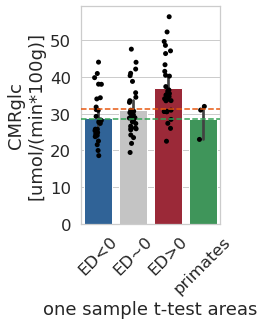

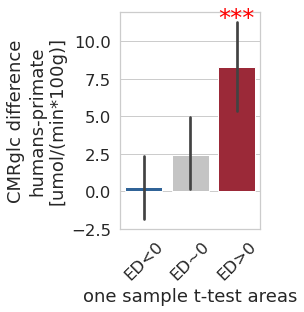

In [220]:
plt.figure(figsize=(2.5,4))
sns.barplot(x="ostt_signed", y=pet_metric, data=all_ind_vox_vals.groupby(['sid','ostt_signed'],as_index=False).median(),hue="ostt_signed",dodge=False,
            palette=np.concatenate((getattr(plt.cm,sel_cm)(range(256))[24][np.newaxis,:],np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[231][np.newaxis,:],plt.cm.tab20c(range(20))[8][np.newaxis,:]),axis=0))
plt.gca().get_legend().remove()
sns.stripplot(x="ostt_signed", y=pet_metric, data=all_ind_vox_vals.groupby(['sid','ostt_signed'],as_index=False).median(),color='k')
plt.gca().set_ylabel('\n'.join(ylabel.split(' ')))
plt.gca().set_xticklabels(['ED<0', 'ED~0', 'ED>0', 'primates'])
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=45)
plt.gca().set_xlabel('one sample t-test areas')
plt.gca().axhline(all_ind_vox_vals.loc[all_ind_vox_vals.ostt_signed==2,y_var].mean(), 0, 1, linestyle='dashed', color=plt.cm.tab20c(range(20))[8], lw=1.5,zorder=10)
plt.gca().axhline(all_ind_vox_vals.groupby(['roi_id'],as_index=False).median()[pet_metric].mean(), 0, 1, linestyle='dashed', color=plt.cm.tab20c(range(20))[4], lw=1.5,zorder=10)

plt.figure(figsize=(2.5,4))
apes_diff_sign_df = all_ind_vox_vals[(all_ind_vox_vals.ostt_signed!=2)].groupby(['sid','ostt_signed'],as_index=False).median()
sns.barplot(x="ostt_signed", y=pet_metric+'_diff_apes', data=apes_diff_sign_df,hue="ostt_signed",dodge=False,
            palette=np.concatenate((getattr(plt.cm,sel_cm)(range(256))[24][np.newaxis,:],np.array(gray_c)[np.newaxis,:],getattr(plt.cm,sel_cm)(range(256))[231][np.newaxis,:]),axis=0))
plt.gca().get_legend().remove()
plt.gca().set(xlabel='one sample t-test areas', ylabel='CMRglc difference\nhumans-primate\n[umol/(min*100g)]', xticklabels=['ED<0', 'ED~0', 'ED>0'])
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=45)

apes_diff_sign = []
for ix in range(-1,2):
    apes_diff_sign += [stats.ttest_1samp(apes_diff_sign_df[apes_diff_sign_df.ostt_signed==ix].cmrglc_diff_apes.to_numpy(), 0)[1]]
apes_diff_sign = pg.multicomp(np.array(apes_diff_sign),method='bonf')[1]
for ix in range(len(apes_diff_sign_df.ostt_signed.unique())):
    if apes_diff_sign[ix]<0.055:
        sign_text = '***' if apes_diff_sign[ix]<0.0001 else '*'
        plt.gca().text(ix, plt.gca().get_ylim()[1]-1.25, sign_text, ha='center', va='bottom', color='r', size=24)


#### 3C. Allometric brain expansion

Missing ROIs: [88, 90, 92, 93, 110, 118, 120, 122, 131, 135, 166, 172]


Text(0.18134752642363305, -10.759534282, 'energy_density ~  -2.85 + expansion^0.88')

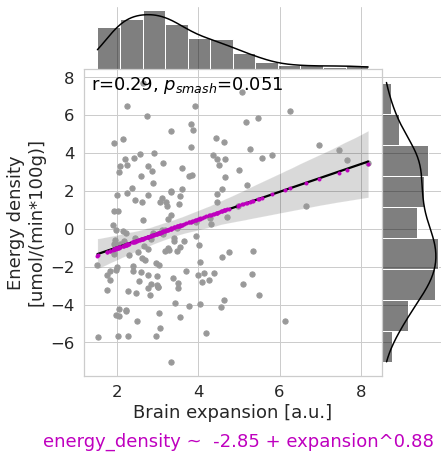

In [228]:
chimp2human_expansion = []
for _, h in enumerate(['lh', 'rh']):
    chimp2human_expansion = np.append(chimp2human_expansion, nib.load(os.path.join(root_dir,'external',f'Wei2019/{h}.32k.chimp2humanF.smoothed15.shape.gii')).darrays[0].data)
chimp2human_expansion = surface_to_parcel(chimp2human_expansion,'glasser_360_conte69')[1:]
avg_roi_ed_vals= src.functions.metric2mmp(all_avg_roi_vals,'energy_density','roi_id')

src.functions.smash_comp(chimp2human_expansion[:180],avg_roi_ed_vals,None,y_nii_fn=os.path.join(results_dir,'figures',f'fig3C_allometric_ed-chimp2humanexpansion.png'),
           l=5,u=95,n_mad='min',ylabel='Energy density\n[umol/(min*100g)]', xlabel='Brain expansion [a.u.]',p_uthr=1,plot=True,
           cmap=ListedColormap(extended_cm),print_text=True,plot_rnd=False,plot_surface=False,x_surr_corrs=cohorts_metadata['all']['smash_sd_{}-{}'.format(x_var,y_var)],
          )

valid_ind = src.functions.valid_data_index(chimp2human_expansion[:180],avg_roi_ed_vals,n_mad='min')
allometric_fit_params,_ = curve_fit(src.functions.allometric_fit, chimp2human_expansion[:180][valid_ind],avg_roi_ed_vals[valid_ind])
plt.gca().plot(chimp2human_expansion[:180][valid_ind],allometric_fit_params[1] + chimp2human_expansion[:180][valid_ind]**allometric_fit_params[0],'.m')#[0.90196078, 0.33333333, 0.05098039])

allometric_model = allometric_model = r'energy_density ~  %0.2f + expansion^%0.2f' % (allometric_fit_params[1],allometric_fit_params[0])
plt.gca().text(plt.gca().get_xlim()[0]-1,plt.gca().get_ylim()[0]-3, allometric_model, ha='left',va='top', color='m')

### Figure 4. Layer specific cellular organization of energy dense regions
#### 4A. Histological cell density across cortical layers 

[Text(0.5, 0, 'staining\nintensity')]

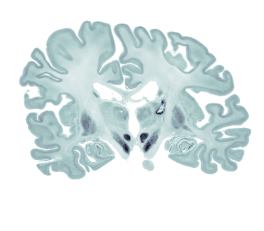

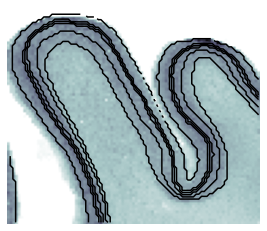

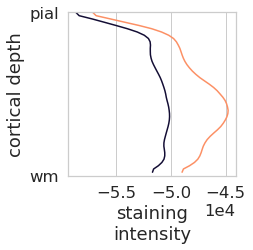

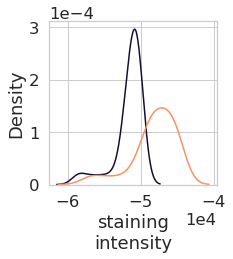

In [237]:
## Ultra-high resolution histological slice from the BigBrain atlas
bb_vol = nib.load(os.path.join(root_dir,'external','kwagstyl_cortical_layers_tutorial','full8_200um_optbal.nii.gz'))
bb_layers = nib.load(os.path.join(root_dir,'external','kwagstyl_cortical_layers_tutorial','segmentation_200um.nii.gz'))
section = 385 # seleceted arbitrarily
bb_layers_section=bb_layers.dataobj[section]
bb_histo_section = bb_vol.dataobj[section]
plt.imshow(np.flipud(bb_histo_section),cmap='bone')
plt.gca().axis('off')
plt.figure()
plt.imshow(np.flipud(bb_histo_section[480:560,297:390]),cmap='bone') # seleceted arbitrarily
plt.gca().axis('off')
bb_layers_section[bb_layers_section<1]=np.nan
bb_layers_section[np.isin(bb_layers_section,[2,3,5,6])]=np.nan
plt.gca().contour(np.flipud(bb_layers_section[480:560,297:390]), colors='k')

## Big brain upsample to 50 cortical layers between pial and white matter surfaces
bb_profiles = np.loadtxt(os.path.join(root_dir,'external','BigBrainWarp','tpl-fs_LR_den-32k_desc-profiles.txt'),delimiter=',')
bb_profiles_inv = bb_profiles * -1
bb_profiles_inv_all = surface_to_parcel(np.sum(bb_profiles_inv,axis=0),'glasser_360_conte69')[1:]
bbl_roi = np.array([])
for bb_layer in bb_profiles_inv:
    bbl_roi = np.append(bbl_roi,surface_to_parcel(np.array(bb_layer),'glasser_360_conte69')[1:][np.newaxis,:],axis=0) if bbl_roi.shape[0]>0 else surface_to_parcel(np.array(bb_layer),'glasser_360_conte69')[1:][np.newaxis,:]
bbl_roi_mean = np.mean(bbl_roi,axis=0)
bbl_roi_skew = []
for bbp in bbl_roi.T:
    bbl_roi_skew += [stats.skew(bbp, bias=True)]
bbl_roi_skew = np.array(bbl_roi_skew)

##example datapoints selected visually from the scatter plot
lskew = np.where((bbl_roi_skew[:180]>-2.25) & (bbl_roi_skew[:180]<-2.2) & (avg_roi_ed_vals>5))[0][0]
hskew=np.where((bbl_roi_skew[:180]<-1.38) & (bbl_roi_skew[:180]>-1.4) & (avg_roi_ed_vals<0) & (avg_roi_ed_vals>-0.3))[0][0]

plt.figure(figsize=(3,3))
plt.plot(bbl_roi[:,lskew],np.arange(50,0,-1),color=getattr(plt.cm,'magma')(range(256))[24],label='left')
plt.plot(bbl_roi[:,hskew],np.arange(50,0,-1),color=getattr(plt.cm,'magma')(range(256))[196],label='right') #231
plt.gca().set(ylim=(0,50),yticks=(0,50),yticklabels=['wm','pial'],xlabel='staining\nintensity',ylabel='cortical depth')
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 1))

plt.figure(figsize=(3,3))
sns.kdeplot(bbl_roi[:,lskew],color=getattr(plt.cm,'magma')(range(256))[24],label='left')
sns.kdeplot(bbl_roi[:,hskew],color=getattr(plt.cm,'magma')(range(256))[196],label='right')#231
plt.gca().yaxis.get_major_formatter().set_powerlimits((0, 1))
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 1))
plt.gca().set(xlabel='staining\nintensity')


#### 4B. Energy density relationship with cell density in infragranular layers 

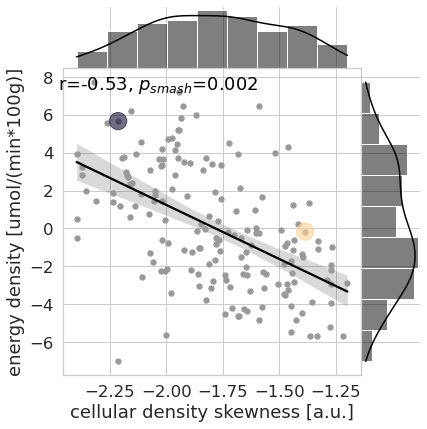

In [238]:
src.functions.smash_comp(bbl_roi_skew[:180],avg_roi_ed_vals,None,y_nii_fn=os.path.join(results_dir,'figures',f'fig4B_bb-skew_vs_ed.png'),
                         ylabel='energy density [umol/(min*100g)]', xlabel='cellular density skewness [a.u.]',
                         l=5,u=95,n_mad='min',p_uthr=1,plot=True,cmap=ListedColormap(extended_cm),print_text=False,plot_rnd=False,plot_surface=False,
                         x_surr_corrs=cohorts_metadata['all']['smash_bb-skew_{}-{}'.format(x_var,y_var)])
plt.gca().scatter(bbl_roi_skew[[lskew,hskew]],avg_roi_ed_vals[[lskew,hskew]],s=300, alpha=0.6,
                  c=np.concatenate((getattr(plt.cm,'magma')(range(256))[24][np.newaxis,:],getattr(plt.cm,'magma')(range(256))[231][np.newaxis,:]),axis=0))
#plt.figure()
#plot_surf(np.array(bbl_roi_skew[:180]),os.path.join(img_dir,'bb_skew'),colorbar=True,cmap='magma',fig_title='BB skewness',vlow=5,vhigh=95)

#### 4C. Energy density relationship with transcription levels for signaling

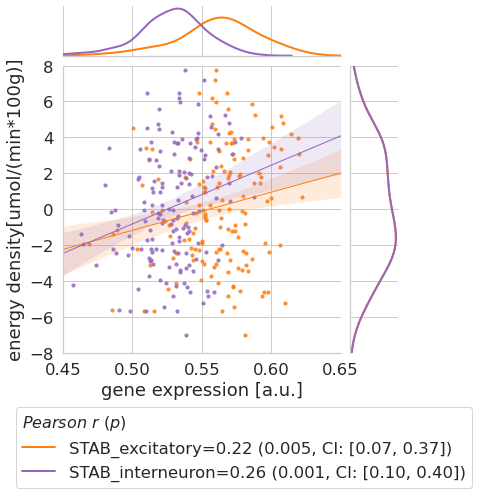

<Figure size 432x288 with 0 Axes>

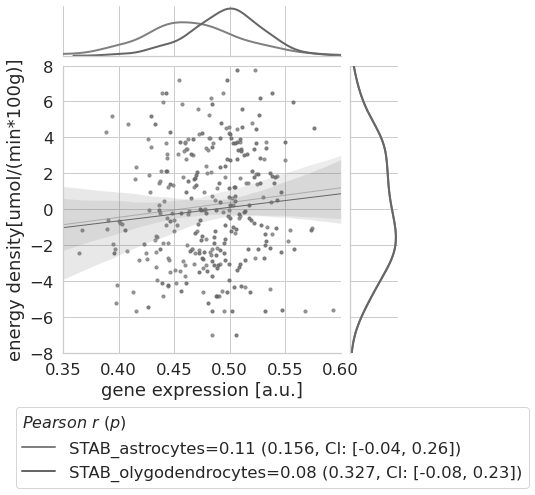

In [235]:
ahba_gene_expression = fetch_ahba(os.path.join(root_dir,'external','AHBA','allgenes_stable_r0.2_glasser_360.csv'))
stab_genesets = ['STAB_excitatory','STAB_interneuron','STAB_astrocytes','STAB_olygodendrocytes']
stab_geneset_clusters = {}
stab_geneset_clusters['STAB_excitatory'] = ['ExN1_4','ExN1a','ExN1b','ExN1c','ExN2','ExN3','ExN4','ExN5','ExN6a','ExN6b','ExN8','ExN9','ExN10','ExN11']
stab_geneset_clusters['STAB_interneuron'] = ['InN1a','InN1b','InN3','InN4a','InN4b','InN4_5','InN5','InN5_6','InN6','InN7_8']
stab_geneset_clusters['STAB_astrocytes'] = ['Astro1','Astro2','Astro3','Astro4']
stab_geneset_clusters['STAB_olygodendrocytes'] = ['Olig1','Olig3','Olig4','NPC']
stab_gene_expression_df = pd.DataFrame({})
for geneset in stab_genesets:
    stab_genesets_clusters_gene_ids = []
    for geneset_cluster in stab_geneset_clusters[geneset]:
        stab_genesets_clusters_gene_ids += pd.read_csv(os.path.join(root_dir,'external','STAB2021',f'{geneset_cluster}.tsv'),sep='\t')['symbol'].to_list()
    stab_gene_expression_df = pd.concat([stab_gene_expression_df,
                                         pd.DataFrame({'energy_density':avg_roi_ed_vals,
                                                       'gene_expression':src.functions.gx_gene_exp(ahba_gene_expression,stab_genesets_clusters_gene_ids,mmp_n,agg_func='nanmean')[:180],
                                                       'type':geneset})],
                                        ignore_index=True)
                
stab_gene_expression_df = stab_gene_expression_df[(stab_gene_expression_df.energy_density>stab_gene_expression_df.energy_density.min()) & (stab_gene_expression_df.gene_expression>stab_gene_expression_df.gene_expression.min())]        
    
stab_filter_labels = ['STAB_excitatory','STAB_interneuron']
stab_palette_regplot = [sns.color_palette()[1],sns.color_palette()[4]]
xlab='gene_expression'
ylab='energy_density'
stab_filtered_index_lists=[]
for stab_filt in stab_filter_labels:
    stab_filtered_index_lists+=[stab_gene_expression_df.type==stab_filt]
src.functions.multiple_joinplot(stab_gene_expression_df,xlab,ylab,stab_filtered_index_lists,[],stab_filter_labels,stab_palette_regplot,[],
                  xlabel='gene expression [a.u.]',ylabel='energy density[umol/(min*100g)]',xlim=(0.45,0.65),ylim=(-8,8),s=10,print_ci=True)
plt.figure()
stab_filter_labels = ['STAB_astrocytes','STAB_olygodendrocytes']
stab_palette_regplot = [(0.5,0.5,0.5,0.5),(0.4,0.4,0.4,1)]
stab_filtered_index_lists=[]
for stab_filt in stab_filter_labels:
    stab_filtered_index_lists+=[stab_gene_expression_df.type==stab_filt]
src.functions.multiple_joinplot(stab_gene_expression_df,xlab,ylab,stab_filtered_index_lists,[],stab_filter_labels,stab_palette_regplot,[],
                  xlabel='gene expression [a.u.]',ylabel='energy density[umol/(min*100g)]',xlim=(0.35,0.60),ylim=(-8,8),s=10,print_ci=True)


### Figure 5. Higher rate of neuromodulation in energy dense regions
#### 5A. Significant correlations between energy density and gene expression of brain specific genes

<AxesSubplot:>

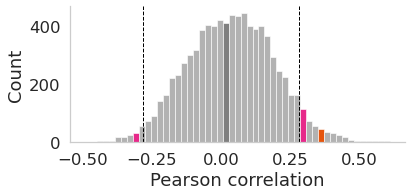

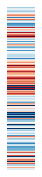

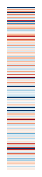

In [230]:
corr_ed_gexp = pd.DataFrame(columns=['gene','r','p'])
for gen in ahba_gene_expression.columns[1:]:
    gene_expression = ahba_gene_expression[gen].to_numpy()[:180]
    gene_expression[np.isnan(gene_expression)]=np.min(gene_expression)-1 if np.min(gene_expression)<0 else 0
    r_ed_gexp_p, p_ed_gexp_p = src.functions.corr_wo_outliers(avg_roi_ed_vals,gene_expression,n_mad=3.5)
    corr_ed_gexp = corr_ed_gexp.append({'gene':gen,'r':r_ed_gexp_p,'p':p_ed_gexp_p}, ignore_index=True)

_,corr_ed_gexp['p_fdr'] = pg.multicomp(corr_ed_gexp['p'].to_numpy().astype(np.float32),method='fdr_bh')

plt.figure(figsize=(6,2.5))
sns.histplot(data=corr_ed_gexp, x="r",color=(0.6,0.6,0.6))
## Statsitical significance thresholds
plt.gca().axvline(corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.r<0)].r.max(), 0, 1, color='k', linestyle='dashed', lw=1)
plt.gca().axvline(corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.r>0)].r.min(), 0, 1, color='k', linestyle='dashed', lw=1)

hist_data = np.histogram_bin_edges(corr_ed_gexp.r.to_numpy(), bins=len(plt.gca().patches))
sel_genes_colors = [plt.cm.Dark2(range(8))[3].flatten(),plt.cm.Dark2(range(8))[3].flatten(),plt.cm.tab20c([4]).flatten()]
gene_ids_with_pet_available = np.array(['OPRM1','HTR4','CHRNA4']) # derived from figure 5E, buzt used here to don't duplicate the histogram there
for cix,sel_gene in enumerate(gene_ids_with_pet_available):
    patch_index = (np.abs((hist_data-corr_ed_gexp[(corr_ed_gexp.p_fdr<=0.005) & (corr_ed_gexp.gene==sel_gene)].r.item()))).argmin()
    plt.gca().patches[patch_index].set_facecolor(sel_genes_colors[cix])
patch_index = (np.abs((hist_data-0))).argmin() #0 correlation gene
plt.gca().patches[patch_index].set_facecolor('gray')
[s.set_visible(False) for s in [plt.gca().spines['top'], plt.gca().spines['right']]]
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(False)
plt.gca().set_xlabel('Pearson correlation')

gene_exp_null_corr = ahba_gene_expression[corr_ed_gexp[(corr_ed_gexp.r>0) & (corr_ed_gexp.r<=0.000011)].gene.item()].to_numpy()[:180] # gen non-correlated with the energy density chosen arbitrary
gene_exp_null_corr[np.isnan(gene_exp_null_corr)]=np.min(gene_exp_null_corr)-1 if np.min(gene_exp_null_corr)<0 else 0
plt.figure(figsize=(0.5,3))
sns.heatmap(avg_roi_ed_vals[:,np.newaxis],cbar=False, xticklabels=False,yticklabels=False,cmap=sel_cm)
plt.figure(figsize=(0.5,3))
sns.heatmap(gene_exp_null_corr[:,np.newaxis],cbar=False, xticklabels=False,yticklabels=False,cmap=sel_cm)

#plt.figure()
#plot_surf(gene_exp_null_corr,os.path.join(img_dir,corr_ed_gen[(corr_ed_gen.r>0) & (corr_ed_gen.r<=0.000011)].gene.item()),colorbar=False,cmap=ListedColormap(extended_cm),vlow=5,vhigh=95)#
#plt.figure()
#plot_surf(ed_180rois,os.path.join(img_dir,'avg_sign_density_4coh'),colorbar=False,cmap=ListedColormap(extended_cm),vlow=5,vhigh=95)



#### 5B. Gene ontology (GO): cellular components

Text(0.5, 1.0, '$\\bf{Enrichment}$ Gene ontology - cellular component')

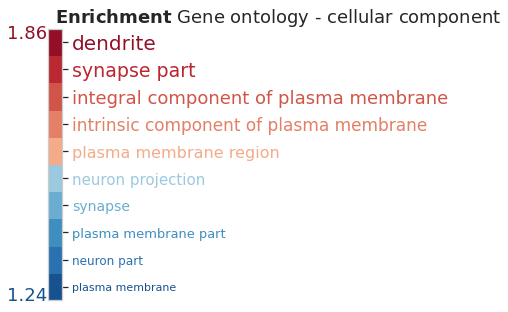

In [283]:
go_cell_comps = pd.read_csv(os.path.join(root_dir,'CompEnrichment_SD_AHBA_fdr0005_all_bgGTEx_Allsign.txt'),sep='\t')
go_cell_comps = go_cell_comps.sort_values(by='Enrichment',ignore_index=True) # Highest enrichment goes on the top
go_cell_comps['-log10(p_FDR)'] = -np.log10(go_cell_comps['FDR q-value'])

cix = 17
clrs_bar = []
for ix in range(go_cell_comps.shape[0]):
    clrs_bar+=[extended_cm[cix]]
    cix=cix+16 if cix!=81 else cix+16*6  
fig, ax = plt.subplots(figsize=(0.25,5))
cb = colorbar.ColorbarBase(ax, cmap=ListedColormap(clrs_bar), orientation = 'vertical',ticks=np.arange(0.05,1,0.1))
go_cell_comps_tickl = go_cell_comps.Description.to_list()
cb.ax.set_yticklabels(go_cell_comps_tickl) 
for yix,ytickl in enumerate(cb.ax.get_yticklabels()):
    ytickl.set_color(clrs_bar[yix])
    ytickl.set_fontsize(10+yix+1)
cb.ax.text(-1.5, 0.05, go_cell_comps.loc[0,"Enrichment"],color=clrs_bar[0], transform=cb.ax.transAxes, va='top', ha='center')
cb.ax.text(-1.5, 0.95, go_cell_comps.loc[go_cell_comps.shape[0]-1,"Enrichment"],color=clrs_bar[-1], transform=cb.ax.transAxes, va='bottom', ha='center')
cb.ax.set_title( r'$\bf{Enrichment}$ Gene ontology - cellular component',fontdict={'horizontalalignment':'left'})


#### 5C. GO: molecular functions

Text(0.0, 1.0, 'Enrichment')

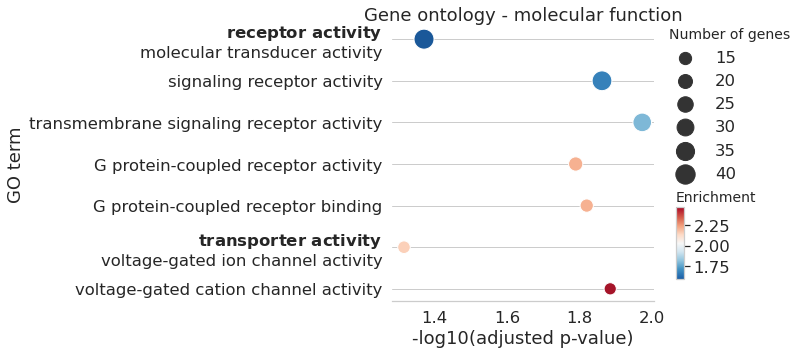

In [197]:
go_mol_funcs = pd.read_csv(os.path.join(root_dir,'FPenrichment_SD_AHBA_fdr0005_all_bgGTEx_Allsign.txt'),sep='\t')
go_mol_funcs['-log10(adjusted p-value)'] = -np.log10(go_mol_funcs['FDR q-value'])
go_mol_funcs = go_mol_funcs.sort_values(by='FDR q-value',ignore_index=True,ascending=False)
go_mol_funcs['id']=go_mol_funcs.index+1
go_mol_funcs_sort_order={6:1,1:2,4:3,3:4,7:5,5:6,2:7}
go_mol_funcs['sorted_id'] = go_mol_funcs['id'].map(go_mol_funcs_sort_order)
go_mol_funcs.loc[go_mol_funcs.Description=='molecular transducer activity','Description'] = r'$\bf{receptor\ activity}$'+'\nmolecular transducer activity'
go_mol_funcs.loc[go_mol_funcs.Description=='voltage-gated ion channel activity','Description'] = r'$\bf{transporter\ activity}$'+'\nvoltage-gated ion channel activity'
go_mol_funcs = go_mol_funcs.sort_values(by='sorted_id',ignore_index=True,ascending=False)
g = sns.relplot(data=go_mol_funcs, x="-log10(adjusted p-value)", y="sorted_id", hue="Enrichment",size="Number of genes",palette=ListedColormap(extended_cm[20:236]),sizes=(150,400))
plt.gca().set_yticks(go_mol_funcs.sorted_id.to_list())
plt.gca().set_yticklabels(go_mol_funcs.Description.to_list())
[s.set_visible(False) for s in [plt.gca().spines['top'], plt.gca().spines['left'], plt.gca().spines['right']]]
plt.gca().xaxis.grid(False)
plt.gca().set_ylabel('GO term')
plt.gca().set_title('Gene ontology - molecular function')
orig_leg = plt.gca().get_legend_handles_labels()
g._legend.remove()
leg = plt.legend(orig_leg[0][8:],orig_leg[1][8:],bbox_to_anchor=(1,1.05), loc="upper left", frameon=False,title=orig_leg[1][7],title_fontsize=14)
leg._legend_box.align = "left"
axins = inset_axes(g.ax,
                   width="3%",  # width = 3% of parent_bbox width
                   height="25%",
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.05, 1.05, 1.05),
                   bbox_transform=g.ax.transAxes
                   )
cbar = g.fig.colorbar(plt.cm.ScalarMappable(norm=clrs.Normalize(vmin=go_mol_funcs['Enrichment'].min(), vmax=go_mol_funcs['Enrichment'].max(), clip=False), cmap=ListedColormap(extended_cm[20:236])),cax=axins)
axins.set_title(orig_leg[1][0],fontsize=14,loc='left')

#### 5D. GO: hierarchical summary of molecular functions 

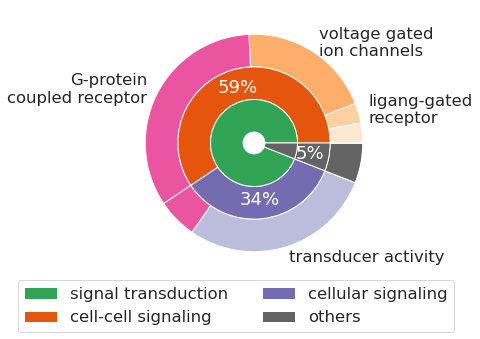

In [198]:
go_genes = pd.read_excel(os.path.join(root_dir,'SD_AHBA_fdr0005_GTExbrainBG_GO_significant_genes.xlsx'),engine='openpyxl',usecols='A:I',nrows=70)
go_genes_summary = go_genes.groupby(['gene_type','gene_type_subcategory'],as_index=False).count()
total_genes = go_genes_summary.gene.sum()
go_genes_pie_data = np.concatenate((go_genes_summary.loc[(go_genes_summary.gene_type=='neurotransmission'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_numpy()[np.newaxis,:],
                                     np.array(go_genes_summary.loc[(go_genes_summary.gene_type=='cellular signaling'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_list()+[0,0])[np.newaxis,:],
                                     np.array(go_genes_summary.loc[(go_genes_summary.gene_type=='others'),['gene_type_subcategory','gene']].sort_values(by='gene').gene.to_list()+[0,0,0])[np.newaxis,:]
                                    ),axis=0)

go_genes_pie_data = np.round(100*go_genes_pie_data/total_genes)
go_genes_pie_labels = go_genes_summary.loc[(go_genes_summary.gene_type=='neurotransmission'),['gene_type_subcategory','gene']].sort_values(by='gene').gene_type_subcategory.to_list()
go_genes_pie_labels[1] = go_genes_pie_labels[0] #only valid because both categories have the same value
go_genes_pie_labels[0] = '' #others
## to make narrow the plot
go_genes_pie_labels[1] = 'ligang-gated\nreceptor'
go_genes_pie_labels[2] = 'voltage gated\nion channels'
go_genes_pie_labels[3] = 'G-protein\ncoupled receptor'
go_genes_pie_labels += go_genes_summary.loc[(go_genes_summary.gene_type=='cellular signaling'),['gene_type_subcategory','gene']].sort_values(by='gene').gene_type_subcategory.to_list()
go_genes_pie_labels[4] = '' #G protein duplicated
go_genes_pie_labels += ['','','','','','']

fig, ax = plt.subplots(figsize=(5,5))
wd0,t0 = ax.pie(go_genes_pie_data.flatten(), radius=1,
                colors=np.concatenate((np.array(list(plt.cm.tab20c(range(20))[7][:3])+[0.5])[np.newaxis,:],plt.cm.tab20c(range(20))[np.arange(7,5,-1)],
                                       np.array(list(plt.cm.Dark2(range(8))[3][:3])+[0.8])[np.newaxis,:],np.array(list(plt.cm.Dark2(range(8))[3][:3])+[0.8])[np.newaxis,:],
                                       plt.cm.tab20c(range(20))[14:16],np.concatenate((plt.cm.tab20c(range(20))[15][:3],[0.5]))[np.newaxis,:],
                                       np.repeat(np.array([plt.cm.tab20c(range(20))[16]]),4,axis=0)),axis=0),
                labels=go_genes_pie_labels,wedgeprops=dict(width=0.3, edgecolor='w'),labeldistance=1.1)

wd,_,_ =ax.pie(go_genes_pie_data.sum(axis=1), radius=0.7, colors=plt.cm.tab20c(range(20))[[4,12,16]],
       wedgeprops=dict(width=0.3, edgecolor='w'),autopct='%d%%',textprops=dict(color="w"),pctdistance=0.75)
wd1,_ =ax.pie(np.array([np.sum(go_genes_pie_data[:2]),np.sum(go_genes_pie_data[-1])]), radius=0.4, colors=plt.cm.tab20c(range(20))[[8,16]],
       wedgeprops=dict(width=0.3, edgecolor='w'))
ax.set(aspect="equal")
ax.legend([wd1[0]]+wd, ['signal transduction','cell-cell signaling','cellular signaling','others'],
          loc='lower left', ncol=2, bbox_to_anchor=(-0.4, -0.225))

#### 5E. Validation of relationship between energy density and receptor density expression from receptor-PET imaging

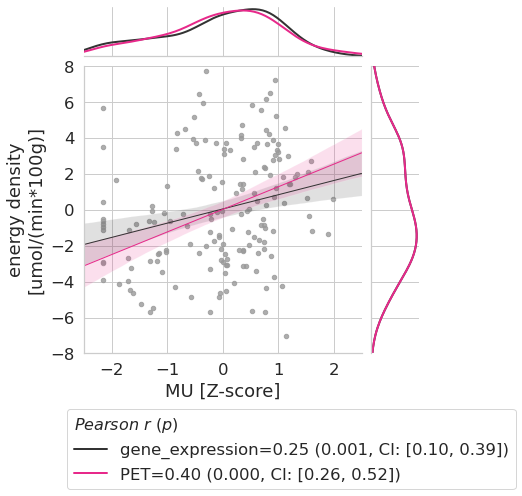

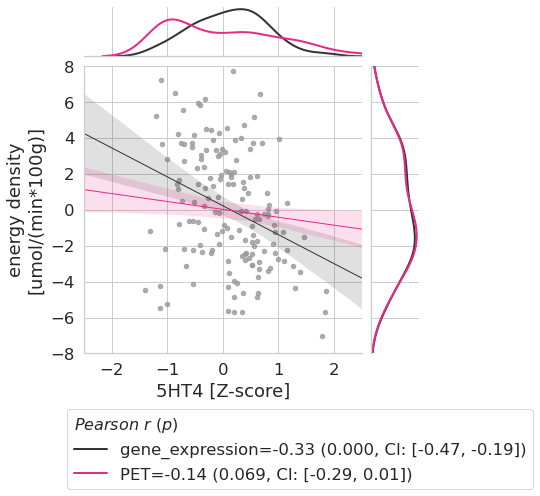

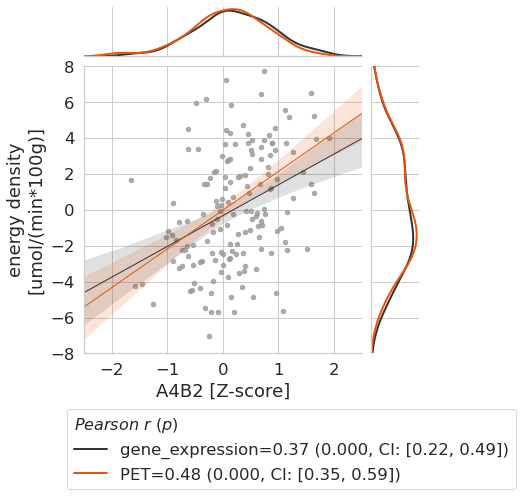

In [234]:
ext_pet_roi_maps = pd.read_csv(os.path.join(root_dir,'external','Hansen2021','Hansen2021_19-pet-tracers_roi.csv'))
ext_pet_roi_maps[ext_pet_roi_maps.columns[ext_pet_roi_maps.columns!='roi_id']] = ext_pet_roi_maps[ext_pet_roi_maps.columns[ext_pet_roi_maps.columns!='roi_id']].apply(stats.zscore)
tracer_labels = np.array(['MU','5HT4','A4B2'])
gexp_pet_df = ext_pet_roi_maps[['roi_id']+list(tracer_labels)]
gexp_pet_df = gexp_pet_df[gexp_pet_df.roi_id<=180] #only left hemisphere acquired in all AHBA subjects
gexp_pet_df['energy_density'] = avg_roi_ed_vals[(gexp_pet_df.roi_id.unique()-1).astype(int)]
gexp_pet_df = gexp_pet_df.melt(['roi_id','energy_density'],var_name='neuromodulator',ignore_index=False)
gexp_pet_df['source'] = 'PET'

gexp_with_pet_available_df = ahba_gene_expression[gene_ids_with_pet_available][:180].apply(stats.zscore)
gexp_with_pet_available_df.columns = tracer_labels
gexp_with_pet_available_df = gexp_with_pet_available_df[gexp_with_pet_available_df.index.isin(gexp_pet_df.roi_id.unique()-1)]
gexp_with_pet_available_df['energy_density'] = avg_roi_ed_vals[(gexp_pet_df.roi_id.unique()-1).astype(int)]
gexp_with_pet_available_df['roi_id'] = gexp_pet_df.roi_id.unique()
gexp_with_pet_available_df = gexp_with_pet_available_df.melt(['roi_id','energy_density'],var_name='neuromodulator',ignore_index=False)
gexp_with_pet_available_df['source'] = 'gene_expression'

gexp_pet_df = pd.concat([gexp_pet_df,gexp_with_pet_available_df], ignore_index=True)
for nt in tracer_labels:
    pet_color = plt.cm.Dark2(range(8))[3].flatten() if nt!='A4B2' else plt.cm.tab20c([4]).flatten()
    src.functions.multiple_joinplot(gexp_pet_df,'value','energy_density',[((gexp_pet_df.neuromodulator==nt) & (gexp_pet_df.source=='gene_expression')),((gexp_pet_df.neuromodulator==nt) & (gexp_pet_df.source=='PET'))],
                      [],['gene_expression','PET'],[(0.2,0.2,0.2,1),pet_color],(0.6,0.6,0.6,0.6),s=20,xlim=(-2.5,2.5),ylim=(-8,8),
                      xlabel=nt+' [Z-score]',ylabel='energy density\n[umol/(min*100g)]',legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=True,mad_thr=3.5,print_ci=True)


#### 5F. Energy density variance explained by external receptor-PET density-maps

[0.89023454 0.06849691 0.01996979]
[0.000999   0.000999   0.02197802]


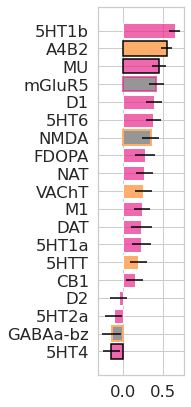

In [36]:
ext_pet_roi_maps_mat = stats.zscore(ext_pet_roi_maps.to_numpy()[:,1:], axis=0)
ext_pet_labels = ext_pet_roi_maps.columns[1:].to_list()
all_ind_roi_ed_vals = all_ind_roi_vals.groupby(['sid','roi_id'],as_index=False).median()[['sid','roi_id','energy_density']].pivot(index='roi_id',columns='sid', values='energy_density').reset_index()
all_ind_roi_ed_vals = all_ind_roi_ed_vals[all_ind_roi_ed_vals.roi_id.isin(ext_pet_roi_maps.roi_id.unique())]
all_ind_roi_ed_vals_mat= stats.zscore(all_ind_roi_ed_vals.to_numpy(), axis=0,nan_policy='omit')[:,1:]
all_ind_roi_ed_vals_mat = np.nan_to_num(all_ind_roi_ed_vals_mat)

#PLS
ed_ext_pet_roi_pls = pyls.behavioral_pls(all_ind_roi_ed_vals_mat,ext_pet_roi_maps_mat,n_perm=1000,n_boot=1000,n_proc=6)
n_sign_comp = (ed_ext_pet_roi_pls.permres.pvals<=0.05).sum()
print(ed_ext_pet_roi_pls.varexp[:n_sign_comp])
print(ed_ext_pet_roi_pls.permres.pvals[:n_sign_comp])
icx = 0 # Selected component

ext_pet_colors = np.repeat(np.array(list(plt.cm.Dark2(range(8))[3][:3])+[0.7])[np.newaxis,:],len(ext_pet_labels),axis=0)
ext_pet_colors[5:7] = plt.cm.tab20c([6]).flatten()
ext_pet_colors[12] = plt.cm.tab20c([17]).flatten()
ext_pet_colors[16] = plt.cm.tab20c([17]).flatten()
ext_pet_colors[17] = plt.cm.tab20c([6]).flatten()
ext_pet_colors[18] = plt.cm.tab20c([17]).flatten()

fig, axs = plt.subplots(1, 1, figsize=(3, 6))
ext_pet_colors_mod = ext_pet_colors.copy()
err = (ed_ext_pet_roi_pls["bootres"]["y_loadings_ci"][:, icx, 1] - ed_ext_pet_roi_pls["bootres"]["y_loadings_ci"][:, icx, 0]) / 2
sorted_idx = np.argsort(ed_ext_pet_roi_pls["y_loadings"][:, icx])#[::-1] 
significance_index = np.zeros(len(ext_pet_labels), dtype=bool)    
axs.barh(np.arange(len(err)), np.sort(ed_ext_pet_roi_pls["y_loadings"][:, icx]),xerr=err[sorted_idx],color=ext_pet_colors_mod[sorted_idx])
axs.set_yticks(np.arange(ext_pet_roi_maps.shape[1]-1))#, labels=ext_pet_roi_df.columns[1:].to_numpy()[relidx])
axs.set_yticklabels(ext_pet_roi_maps.columns[1:].to_numpy()[sorted_idx])
for patch in  [i for (i, v) in zip(axs.patches, np.isin(ext_pet_roi_maps.columns[1:].to_numpy()[sorted_idx],['A4B2','MU','5HT4'])) if v]:
    patch.set(edgecolor='k',linewidth=1.5)
axs.patches[np.where((np.array(ext_pet_labels)=='mGluR5')[sorted_idx])[0][0]].set(edgecolor=list(plt.cm.Dark2(range(8))[3][:3])+[0.7],linewidth=2)
axs.patches[np.where((np.array(ext_pet_labels)=='GABAa-bz')[sorted_idx])[0][0]].set(edgecolor=plt.cm.tab20c([6]).flatten(),linewidth=2)
axs.patches[np.where((np.array(ext_pet_labels)=='NMDA')[sorted_idx])[0][0]].set(edgecolor=plt.cm.tab20c([6]).flatten(),linewidth=2)            
        
#plt.figure()
#plot_surf(metric2mmp(pd.DataFrame({'roi_id':valid_roi_ids,'ed_score':ed_ext_pet_roi_pls.x_scores[:,icx]}),'ed_score','roi_id'),
#          os.path.join(img_dir,f'ed_score_{icx}'),colorbar=True,cmap=sel_cm,fig_title=f'ED score {icx}',vlow=5,vhigh=95)
fig.tight_layout()

### Supplementary figures
#### S1.